# TSTpatching Notebook

 ### 1. Overview & Purpose
 
This notebook demonstrates a systematic approach to understanding and intervening in a Transformer-based time series classifier.
1. **Capture internal activations**.  Cache convolutional embeddings, self-attention outputs, and MLP activations for clean inputs.
2. **Perform targeted patches**. Replace activations from corrupted inputs with those from clean inputs at various granularities (entire heads, individual positions, or MLP layers).
3. **Quantify influence**. Measure how each patch affects the model’s class probabilities to locate the most critical components for correct predictions.
4. **Identify causal circuits**. Aggregate significant patches into a graph of input timesteps → attention heads to reveal pathways driving the model’s decisions.
5. **Visualize results**. Use heatmaps, saliency overlays, and network graphs to interpret and communicate findings.
 

### 2. Imports and Dependencies
- Common Python packages
- Utility / Helper functions for plotting and backend processing from utils.py file
- Aeon for TSC dataset loading
- TST architecture from TSTtrainer.py
- Widgets for interactive notebook

In [16]:
# ============================================================================
# CELL 1: IMPORTS AND SETUP
# ============================================================================

# These two lines enable "autoreload" - when you edit utils.py, the changes
# automatically appear here without restarting the kernel
%load_ext autoreload
%autoreload 2

# --- Set up the working directory ---
import os
# Get the directory where this notebook lives
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
# Go up one level to the project root (parent folder)
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
# Change the current working directory to project root
# This ensures all relative imports work correctly
os.chdir(project_root)

# --- Import core libraries ---
import torch  # PyTorch: the deep learning framework we use
from torch.utils.data import DataLoader, TensorDataset  # For batching data
import numpy as np  # Numerical computing (arrays, math)
import pandas as pd  # Data tables (like Excel in Python)
import matplotlib.pyplot as plt  # Plotting/visualization
import seaborn as sns  # Pretty statistical plots (especially heatmaps)
import networkx as nx  # Graph/network data structures
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Model evaluation

# --- Import our custom patching functions from utils.py ---
from Utilities.utils import (
    # PATCHING FUNCTIONS (the core of this notebook)
    sweep_heads,                  # Patch each attention head individually
    sweep_layerwise_patch,        # Patch all heads in a layer at once
    sweep_mlp_layers,             # Patch each MLP layer individually
    sweep_attention_head_positions,  # Patch each (layer, head, timestep) combo
    sweep_mlp_positions,          # Patch each (layer, timestep) for MLPs
    
    # PLOTTING FUNCTIONS
    plot_influence,               # Heatmap of head importance
    plot_layerwise_influence,     # Bar chart of layer importance
    plot_mlp_influence,           # Bar chart of MLP layer importance
    plot_head_position_patch_heatmap,  # Heatmap of position importance per head
    plot_mlp_position_patch_heatmap,   # Heatmap of position importance for MLPs
    
    # ATTENTION ANALYSIS
    get_attention_saliency,       # Extract attention weights for visualization
    plot_timeseries_with_attention_overlay,  # Show attention on time series
    
    # UTILITY FUNCTIONS
    get_probs,                    # Get model's predicted probabilities
    find_critical_patches,        # Find patches with effect > threshold
    build_causal_graph,           # Build graph from critical patches
    plot_causal_graph,            # Visualize the causal graph
    plot_structured_graph_with_heads,  # Layered graph visualization
    patch_multiple_attention_heads_positions,  # Apply multiple patches at once
    
    # HEAD-TO-HEAD ANALYSIS
    sweep_head_to_head_influence, # How much does one head affect another?
    sweep_head_to_output_deltas,  # How much does each head affect output?
    
    FigureHolder  # Helper class to save figures
)

# --- Import dataset loading and model architecture ---
from aeon.datasets import load_classification  # Load time series datasets
from Utilities.TST_trainer import TimeSeriesTransformer  # Our model class

# --- Import interactive widgets for Jupyter ---
import ipywidgets as widgets  # Interactive UI elements
from ipywidgets import interact, IntSlider, FloatSlider  # Slider widgets

# Create a holder to save figures to PDF later
fig_holder = FigureHolder()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 3. Dataset Preparation
Define the dataset we want to work on here, the preprocess it for model input.

Currently there are three options:
- JapaneseVowels (12 dimensions, 9 classes, length 25)
- PenDigits (2 dimensions, 10 classes, length 8)
- LSST (6 dimensions, 14 classes, length 36)

In [17]:
# ============================================================================
# CELL 2: CHOOSE YOUR DATASET
# ============================================================================
# Pick which dataset to analyze. Options:
#   - "JapaneseVowels": 12 dimensions, 25 timesteps, 9 classes (vowel sounds)
#   - "PenDigits": 2 dimensions (x,y), 8 timesteps, 10 classes (handwritten digits)
#   - "LSST": 6 dimensions, 36 timesteps, 14 classes (astronomical light curves)

DATASET_NAME = "JapaneseVowels"  # <-- CHANGE THIS TO SWITCH DATASETS

In [18]:
# ============================================================================
# CELL 3: LOAD AND PREPROCESS THE DATA
# ============================================================================

# Load data from the aeon library (a time series classification library)
# X_train/X_test: the time series data (features)
# y_train/y_test: the labels (which class each sample belongs to)
X_train, y_train = load_classification(DATASET_NAME, split="train")
X_test, y_test = load_classification(DATASET_NAME, split="test")

# --- Preprocessing function ---
def prep(X):
    """
    Prepare data for the model.
    
    The aeon library returns data as (samples, dimensions, timesteps)
    But our model expects (samples, timesteps, dimensions)
    So we swap axes 1 and 2.
    """
    X_np = X.astype(np.float32)  # Convert to 32-bit float (faster, less memory)
    return np.swapaxes(X_np, 1, 2)  # Swap dimensions and timesteps

# Apply preprocessing and convert to PyTorch tensors
X_test = torch.tensor(prep(X_test))  # Shape: (num_samples, seq_len, input_dim)
y_test = torch.tensor(y_test.astype(np.int64))  # Labels as integers

# Print info about the dataset
print(f"Test set has {X_test.shape[0]} instances, each instance has {X_test.shape[1]} timesteps across {X_test.shape[2]} dimensions.")
print(f"For each instance in the test set there is a true label.")

Test set has 370 instances, each instance has 25 timesteps across 12 dimensions.
For each instance in the test set there is a true label.


### 4. Model Initialization
Set up the TST model and load the pretrained checkpoint.
- Use GPU if available, however evaluation completely feasible on a laptop.
- Model must be instantiated exactly as the pretrained one.

In [19]:
# ============================================================================
# CELL 4: CREATE AND LOAD THE MODEL
# ============================================================================

# --- Choose device (GPU or CPU) ---
# CUDA = NVIDIA GPU. If you have one, it's faster. Otherwise, CPU works fine.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Extract dimensions from data ---
seq_len = X_test.shape[1]      # Number of timesteps (e.g., 25 for JapaneseVowels)
input_dim = X_test.shape[2]    # Number of input channels (e.g., 12 for JapaneseVowels)
num_classes = y_test.max() + 1  # Number of classes (e.g., 9 for JapaneseVowels)
                                 # +1 because labels are 0-indexed

# --- Create the Transformer model ---
# Architecture:
#   Input (seq_len × input_dim)
#   → Conv Embedding (converts input to 128-dim)
#   → Positional Encoding (tells model where in sequence each timestep is)
#   → 3 Transformer Encoder Layers (each with 8 attention heads + MLP)
#   → Max Pooling (aggregate across time)
#   → Classifier (predict class)
model = TimeSeriesTransformer(
    input_dim=input_dim,         # Number of input features per timestep
    num_classes=num_classes,     # Number of output classes to predict
    seq_len=seq_len,             # Length of input sequences
    d_model=128,                 # Hidden dimension throughout the model
    n_head=8,                    # Number of attention heads per layer
    num_encoder_layers=3,        # Number of transformer layers (depth)
    dim_feedforward=256,         # Hidden size of MLP in each layer
    dropout=0.1                  # Regularization (10% of neurons randomly off)
).to(device)  # Move model to GPU/CPU

# Store number of layers for later use
num_layers = len(model.transformer_encoder.layers)  # = 3

# --- Load pre-trained weights ---
# These weights were trained separately and saved to a .pth file
MODEL_NAME = f"TST_models/TST_{DATASET_NAME.lower()}.pth"
model.load_state_dict(  # Load the saved weights into our model
    torch.load(MODEL_NAME, map_location=device, weights_only=True)
)
# If you see "<All keys matched successfully>", the weights loaded correctly!

FileNotFoundError: [Errno 2] No such file or directory: 'TST_models/TST_japanesevowels.pth'

In [ ]:
# ============================================================================
# CELL 5: EVALUATE MODEL AND SHOW CONFUSION MATRIX
# ============================================================================

# --- Set model to evaluation mode ---
# This disables dropout and batch normalization updates
model.eval()

# --- Move data to device (GPU/CPU) ---
X_test_device = X_test.to(device)
y_test_device = y_test.to(device)

# --- Create a DataLoader for batched processing ---
# Batching = process 32 samples at once (faster than one at a time)
batch_size = 32
test_loader = DataLoader(
    TensorDataset(X_test_device, y_test_device),  # Pair inputs with labels
    batch_size=batch_size
)

# --- Run the model on all test data ---
all_preds = []   # Will store all predictions
all_labels = []  # Will store all true labels

with torch.no_grad():  # Disable gradient computation (not training, just evaluating)
    for xb, yb in test_loader:  # Loop through batches
        logits = model(xb)  # Forward pass: input → model → raw scores
        # logits shape: (batch_size, num_classes)
        
        preds = torch.argmax(logits, dim=1)  # Get class with highest score
        # preds shape: (batch_size,)
        
        all_preds.append(preds.cpu())   # Move to CPU and store
        all_labels.append(yb.cpu())     # Store true labels

# --- Combine all batches into single arrays ---
predictions = torch.cat(all_preds).numpy()  # Shape: (num_samples,)
labels = torch.cat(all_labels).numpy()       # Shape: (num_samples,)

# --- Create and display confusion matrix ---
# Confusion matrix shows: for each true class, how many were predicted as each class
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=range(1, cm.shape[1] + 1)  # Labels 1-9 (not 0-8)
)

# --- Plot the confusion matrix ---
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap="Blues", ax=ax, values_format="d")  # "d" = integer format
plt.title(f"Confusion Matrix on {DATASET_NAME} Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# INTERPRETATION: 
# - Diagonal = correct predictions (the more, the better)
# - Off-diagonal = mistakes (row = true, column = predicted)

### 5. Identify Misclassified Examples
Scan trough the test set to find instances where the model predicts the wrong label.
- Sorted by confindence
- Reveal possible targets for patching

In [20]:
# ============================================================================
# CELL 6: FIND ALL PREDICTIONS (CORRECT AND INCORRECT)
# ============================================================================

# Set model to evaluation mode (no training, no dropout)
model.eval()

# List to store prediction info for each sample
predictions = []

with torch.no_grad():  # No gradient computation needed
    for idx in range(len(X_test)):  # Loop through each test sample
        # Get single sample, keeping batch dimension: shape (1, seq_len, input_dim)
        x = X_test[idx:idx+1].to(device)
        
        # Forward pass to get raw logits
        logits = model(x)  # Shape: (1, num_classes)
        
        # Convert logits to probabilities using softmax
        # Softmax: makes all values positive and sum to 1
        probs = torch.softmax(logits, dim=1)  # Shape: (1, num_classes)
        
        # Get predicted class (highest probability)
        pred = probs.argmax(dim=1).item()  # .item() converts tensor to Python int
        
        # Get true class
        true = y_test[idx].item()
        
        # Store info for this sample
        if pred:  # Skip samples with pred=0 (this seems like a bug, should be "if True:")
            predictions.append({
                "idx": idx,                        # Sample index in test set
                "true_label": true,                # Actual class
                "pred_label": pred,                # Predicted class
                "P_true": probs[0, true].item(),   # Probability assigned to true class
                "P_pred": probs[0, pred].item()    # Probability assigned to predicted class
            })

# --- Create a DataFrame and sort by true label ---
df = pd.DataFrame(predictions).sort_values(by="true_label", ascending=True)
df.reset_index(drop=True, inplace=True)  # Reset row numbers
df  # Display the table

# INTERPRETATION:
# - P_true = P_pred means correct prediction
# - P_true < P_pred means misclassification (model was more confident in wrong class)
# - We'll use misclassified samples for patching experiments

,idx,true_label,pred_label,P_true,P_pred
0,0,1,2,0.058914,0.323496
1,30,1,2,0.058596,0.324584
2,29,1,2,0.058968,0.321640
3,28,1,2,0.058562,0.323676
4,27,1,2,0.058401,0.321103
...,...,...,...,...,...
365,343,9,2,0.037365,0.324002
366,341,9,2,0.038167,0.325374
367,368,9,2,0.037416,0.322938
368,354,9,2,0.037754,0.324094


### 6. Selection of instances
1. Denoising: 
    - 1st: *Clean* instance (correct classification)
    - 2nd: *Corrupted* instance (misclassified)
2. Noising:
    - Vice-versa

In [21]:
# ============================================================================
# CELL 7: CHOOSE THE PATCHING MODE
# ============================================================================

# MODE determines the direction of patching:
#
# "denoise" mode:
#   - Source = correctly classified sample (CLEAN)
#   - Target = misclassified sample (CORRUPT)
#   - Question: Can we FIX the misclassification by patching in clean activations?
#   - If yes → we found the components responsible for the error
#
# "noise" mode:
#   - Source = misclassified sample (CORRUPT)  
#   - Target = correctly classified sample (CLEAN)
#   - Question: Can we BREAK the correct prediction by patching in corrupt activations?
#   - If yes → we found the components responsible for the correct prediction

MODE = "denoise"  # <-- CHANGE TO "noise" FOR THE OPPOSITE DIRECTION

In [22]:
# ============================================================================
# CELL 8: SELECT TWO INSTANCES FOR PATCHING
# ============================================================================

# --- Choose two instances from the test set ---
# Look at the table from the previous cell to find good candidates:
# - idx_1 should be correctly classified (true_label == pred_label)
# - idx_2 should be misclassified (true_label != pred_label)
# - Both should have the SAME true_label (same class) for meaningful comparison

idx_1 = 33   # CLEAN: correctly classified sample
idx_2 = 44   # CORRUPT: misclassified sample

# --- Load the instances ---
# X_test[[idx]] uses double brackets to keep the batch dimension
x1 = X_test[[idx_1]].to(device)  # Shape: (1, seq_len, input_dim)
y1 = y_test[[idx_1]].item()       # True label (integer)

x2 = X_test[[idx_2]].to(device)  # Shape: (1, seq_len, input_dim)
y2 = y_test[[idx_2]].item()       # True label (integer)

# --- Assign source and target based on mode ---
if MODE == "denoise":
    # Denoise: patch FROM clean INTO corrupt (try to fix it)
    src, tgt = x1, x2                    # src = clean, tgt = corrupt
    src_label, tgt_label = y1, y2        # Labels
elif MODE == "noise":
    # Noise: patch FROM corrupt INTO clean (try to break it)
    src, tgt = x2, x1                    # src = corrupt, tgt = clean
    src_label, tgt_label = y2, y1        # Labels
else:
    raise ValueError("MODE must be 'denoise' or 'noise'")

# --- Verify model predictions on both instances ---
# Get probability of true class for instance 1
probs_x1 = torch.softmax(model(x1), dim=1)[0][y1].detach().cpu().numpy()
# Get probability of true class for instance 2
probs_x2 = torch.softmax(model(x2), dim=1)[0][y2].detach().cpu().numpy()

# Convert to percentages for display
probs_x1_pct = probs_x1 * 100
probs_x2_pct = probs_x2 * 100

# Print summary
print(f"Instance {idx_1} ground truth label is {y1}, Instance {idx_2} ground truth label is {y2}.")
print(f"The model predicted {y1} for instance {idx_1} with {probs_x1_pct:.2f}% confidence. "
      f"For instance {idx_2} the confidence for label {y2} is {probs_x2_pct:.2f}%.")

# EXPECTED OUTPUT:
# - Instance idx_1 should have ~100% confidence (correct prediction)
# - Instance idx_2 should have low confidence for true label (misclassified)

Instance 33 ground truth label is 2, Instance 44 ground truth label is 2.
The model predicted 2 for instance 33 with 32.09% confidence. For instance 44 the confidence for label 2 is 32.32%.


### 7. Visualizing raw Time Series for the selected instances
First look at the structure of the sequences we are investigating

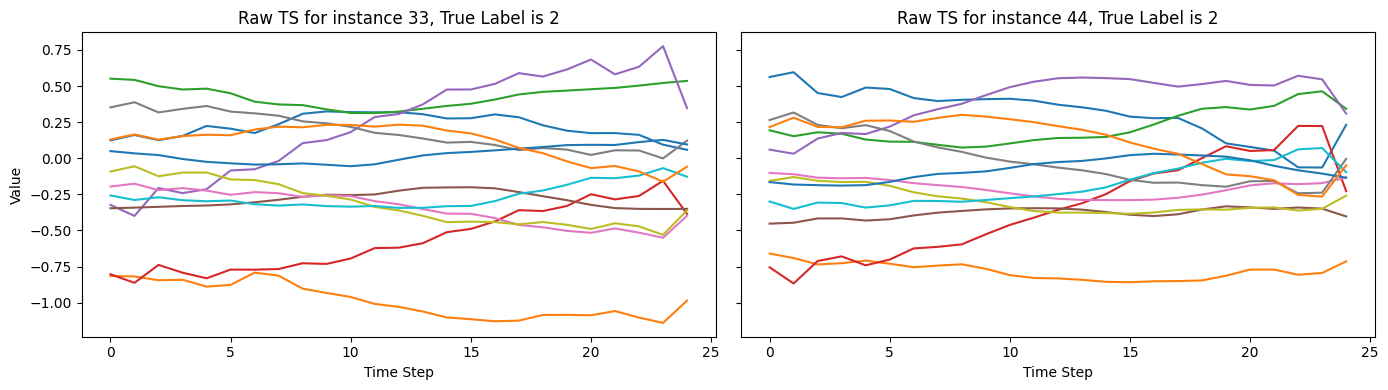

In [23]:
# ============================================================================
# CELL 9: VISUALIZE THE RAW TIME SERIES
# ============================================================================

# Convert tensors to numpy arrays for plotting
# .squeeze() removes the batch dimension, .cpu() moves to CPU, .numpy() converts to array
series_idx_1 = x1.cpu().numpy().squeeze()  # Shape: (seq_len, input_dim)
series_idx_2 = x2.cpu().numpy().squeeze()  # Shape: (seq_len, input_dim)

# --- Create side-by-side plots ---
fig, axes = plt.subplots(
    nrows=1, ncols=2,       # 1 row, 2 columns
    figsize=(14, 4),        # Figure size in inches
    sharey=True             # Same y-axis scale for both plots
)

# --- Plot instance 1 (clean/correct) ---
axes[0].plot(x1.squeeze().cpu().numpy())  # Each column = one dimension
axes[0].set_title(f"Raw TS for instance {idx_1}, True Label is {y1}")
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("Value")

# --- Plot instance 2 (corrupt/misclassified) ---
axes[1].plot(x2.squeeze().cpu().numpy())
axes[1].set_title(f"Raw TS for instance {idx_2}, True Label is {y2}")
axes[1].set_xlabel("Time Step")

plt.tight_layout()  # Prevent overlapping labels
plt.show()

# INTERPRETATION:
# - Each colored line = one dimension of the time series
# - Look for differences between the two instances
# - Even though they have the same label, their patterns may differ slightly

## Patching Experiment: PATCHING EACH ATTENTION HEAD
- **get_probs** records the model's baseline prediction probabilities on the 2nd instance to provide a reference point.
- **sweep_heads** systematically patches each attention head (one at a time) from the first instance into the other while recording the resulting class probabilities.


/Volumes/CS_Stuff/TST-Mechanistic-Interpretability/Utilities/utils.py:436: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


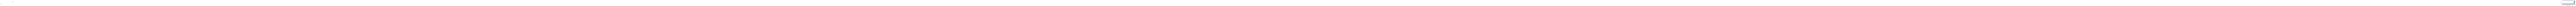

In [25]:
# ============================================================================
# CELL 10: LAYER-WISE PATCHING - Which layer matters most?
# ============================================================================

# --- Get baseline probabilities (no patching) ---
# This runs the target input through the model normally
# Returns: array of probabilities for each class
baseline = get_probs(model, tgt)  # Shape: (num_classes,)
# baseline[tgt_label] = probability of true class BEFORE any patching

# --- Run layer-wise patching ---
# For each layer (0, 1, 2):
#   1. Run tgt through the model
#   2. At that layer, replace ALL attention head outputs with those from src
#   3. Record the resulting probabilities
patched_probs_per_layer = sweep_layerwise_patch(model, src, tgt, num_classes)
# Shape: (num_layers, num_classes) = (3, 9) for JapaneseVowels

# --- Plot the results ---
# Shows ΔP = (prob after patching) - (prob before patching) for the true label
plot_layerwise_influence(patched_probs_per_layer, baseline, tgt_label)

# INTERPRETATION:
# - Positive bars = patching this layer HELPS (increases P(true))
# - Negative bars = patching this layer HURTS (decreases P(true))
# - Tallest bar = most important layer for this prediction
# - Usually Layer 0 is most important (early layers matter more)

### Visualzing Influnece via Heatmap
**plot_influence** computes tbe change in proability  for true label and (ΔP) when each head is patched


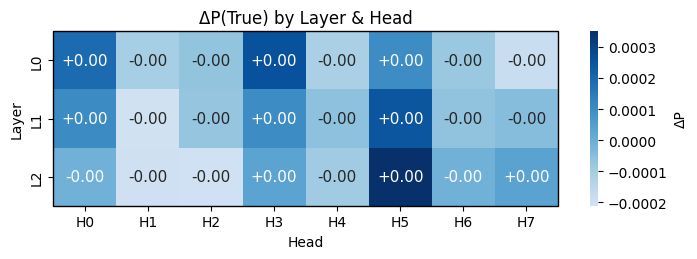

In [26]:
# ============================================================================
# CELL 11: HEAD-WISE PATCHING - Which attention head matters most?
# ============================================================================

# --- Run head-by-head patching ---
# For each of 24 heads (3 layers × 8 heads):
#   1. Run tgt through the model
#   2. Replace ONLY that one head's output with the output from src
#   3. Record the resulting probabilities
#   4. Reset and repeat for the next head
patch_probs = sweep_heads(model, src, tgt, num_classes)
# Shape: (num_layers, num_heads, num_classes) = (3, 8, 9)

# --- Plot as heatmap ---
# Rows = layers (0, 1, 2)
# Columns = heads (0-7)
# Color = ΔP (change in probability for true class)
plot_influence(patch_probs, baseline, tgt_label)

# INTERPRETATION:
# - Brighter cells = patching that head has MORE effect
# - Darker cells = patching that head has LESS effect
# - The brightest head = most important for this prediction
# - Example: If L0H3 is bright, then Layer 0 Head 3 is causally important

X-axis: Attention heads.

Y-axis: Transformer layers.

Cell values: ΔP(true label).

**Interpretation**: Brighter colors indicate heads that, when patched, most improve the model's confidence in the true label

### Attention Overlay
Overlay the attention saliency scores onto the raw time series plots
- Choose a specific (*layer, head*) combination to inspect.

**get_attention_saliency** extracts per-timestep attention weights for each instance

**plot_timeseries_with_attention_overlay** displays the original time series with attention scores visualized as highlighted regions

In [27]:
# ============================================================================
# CELL 12: ATTENTION OVERLAY - Where does each head look?
# ============================================================================

# This creates an INTERACTIVE widget with sliders
# Drag the sliders to explore different layers and heads

@interact(
    # Slider for layer (0, 1, or 2)
    layer_idx=IntSlider(min=0, max=num_layers-1, step=1, value=0),
    # Slider for head (0 through 7)
    head_idx=IntSlider(min=0, max=7, step=1, value=0)
)
def plot_attention_overlay(layer_idx, head_idx):
    """
    Show where this attention head "looks" in the time series.
    
    Attention = which timesteps does the model focus on?
    High attention at timestep 5 → that timestep is important for this head.
    """
    # Get attention saliency (importance) for each timestep
    # Returns: array of shape (seq_len,) with values 0-1
    instances = [src, tgt]  # Both source and target
    saliencies = [
        get_attention_saliency(model, inst, layer_idx, head_idx) 
        for inst in instances
    ]
    labels = ["Source", "Target"]
    
    # Plot time series with attention overlay
    # Brighter background = higher attention at that timestep
    plot_timeseries_with_attention_overlay(
        instances=[inst.squeeze(0) for inst in instances],  # Remove batch dim
        saliencies=saliencies,
        labels=labels,
        title=f"Layer {layer_idx} Head {head_idx} Attention Overlay"
    )

# INTERPRETATION:
# - Colored bands behind the time series = attention weights
# - Brighter = head pays MORE attention to that timestep
# - Darker = head pays LESS attention to that timestep
# - Compare source vs target to see attention differences

interactive(children=(IntSlider(value=0, description='layer_idx', max=2), IntSlider(value=0, description='head…

The colored bands behind the time series indicate how much attention this head pays to each timestep.

Brighter mean higher attention.

Darker bands mean lower attention.

### Patching a specific head at each timestep

**sweep_attention_head_positions** patches the output of each individual head at every position (time step). It then records how patching at each position affects the model’s confidence in the true label.

**plot_head_position_patch_heatmap** shows how important each timestep is for the selected head

In [31]:
# ============================================================================
# CELL 13: POSITION-WISE PATCHING - Which timestep matters for each head?
# ============================================================================

# --- Run position-wise patching for all heads ---
# This is the most fine-grained analysis:
# For each (layer, head, timestep) combination:
#   1. Run tgt through the model
#   2. Replace ONLY that head's output AT THAT TIMESTEP with src's value
#   3. Record probabilities
# This tests all 3 × 8 × 25 = 600 combinations for JapaneseVowels
patch_probs_heads = sweep_attention_head_positions(
    model, src, tgt, 
    num_layers,      # 3 layers
    8,               # 8 heads per layer
    seq_len,         # 25 timesteps
    num_classes      # 9 classes
)
# Shape: (num_layers, num_heads, seq_len, num_classes) = (3, 8, 25, 9)

# --- Interactive visualization ---
@interact(
    layer_idx=IntSlider(min=0, max=num_layers-1, step=1, value=0),
    head_idx=IntSlider(min=0, max=7, step=1, value=0)
)
def plot_patch_effect_heatmap(layer_idx, head_idx):
    """
    Show which timesteps matter most for this specific head.
    """
    plot_head_position_patch_heatmap(
        patch_probs=patch_probs_heads,
        baseline_probs=baseline,
        true_label=tgt_label,
        layer_idx=layer_idx,
        head_idx=head_idx,
        title=f"Head {head_idx} in Layer {layer_idx} - Patch Effect across Time Steps"
    )

# INTERPRETATION:
# - X-axis = timesteps (positions in the sequence)
# - Color = ΔP (effect of patching at that position)
# - Bright spots = patching at this timestep has big effect
# - This tells you WHICH PARTS of the input matter for each head

interactive(children=(IntSlider(value=0, description='layer_idx', max=2), IntSlider(value=0, description='head…

X-axis: Time steps (positions).

Y-axis: Specific (layer, head) combination.

Colors: Change in model probability for the true label.

## Patching Experiment: PATCHING MLP LAYERS

**sweep_mlp_layers** patches the MLP output (after the second linear layer) of each transformer encoder layer individually

**plot_mlp_influence** visualizes the ΔP(true label) from patching each MLP layer

/Volumes/CS_Stuff/TST-Mechanistic-Interpretability/Utilities/utils.py:457: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


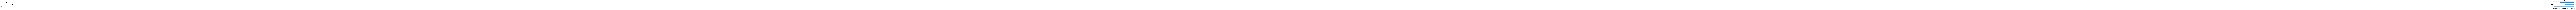

In [32]:
# ============================================================================
# CELL 14: MLP LAYER PATCHING - Which MLP layer matters?
# ============================================================================

# Each transformer layer has TWO parts:
#   1. Self-Attention (what we patched above)
#   2. MLP/Feedforward Network (what we patch here)
#
# The MLP takes the attention output and transforms it:
#   MLP(x) = Linear2(ReLU(Linear1(x)))
#
# This tests whether the MLP computations are important.

# --- Patch each MLP layer ---
# For each layer (0, 1, 2):
#   1. Run tgt through the model
#   2. Replace that layer's MLP output with the MLP output from src
#   3. Record probabilities
patch_probs_mlp = sweep_mlp_layers(model, src, tgt, num_classes=num_classes)
# Shape: (num_layers, num_classes) = (3, 9)

# --- Plot the results ---
plot_mlp_influence(patch_probs_mlp, baseline, true_label=tgt_label)

# INTERPRETATION:
# - Similar to layer-wise attention patching
# - Positive bars = patching MLP helps
# - Usually smaller effects than attention (attention does most of the work)

X-axis: Transformer layers.

Y-axis: Change in model confidence for the true label.

**Interpretation**: Higher positive bars indicate layers whose MLP activations help recover the correct classification more.


### Patching MLP layer at a specific position
**sweep_mlp_positions** patches the MLP activation at each time step. Measure how patching each position’s MLP output affects the true label probability.

**plot_mlp_position_patch_heatmap** shows a heatmap of influence over layers and positions.

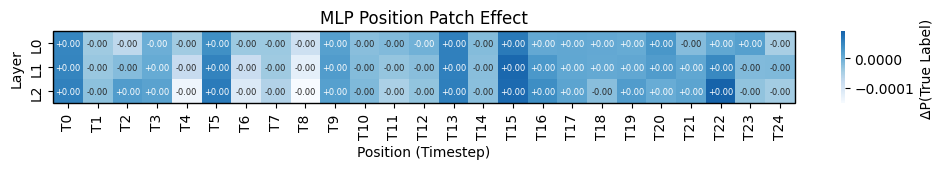

In [33]:
# ============================================================================
# CELL 15: MLP POSITION-WISE PATCHING
# ============================================================================

# --- Patch MLP at each position ---
# For each (layer, timestep) combination:
#   1. Run tgt through the model
#   2. Replace MLP output at that layer and timestep with src's value
#   3. Record probabilities
patch_probs_mlp_pos = sweep_mlp_positions(
    model, src, tgt, 
    num_layers,      # 3 layers
    seq_len,         # 25 timesteps (note: uses seq_len, not input_dim)
    num_classes      # 9 classes
)
# Shape: (num_layers, seq_len, num_classes) = (3, 25, 9)

# --- Plot as heatmap ---
plot_mlp_position_patch_heatmap(
    patch_probs_mlp_pos, 
    baseline, 
    true_label=tgt_label,
    title="MLP Position Patch Effect"
)

# INTERPRETATION:
# - Rows = layers
# - Columns = timesteps
# - Color = ΔP
# - Shows which positions are important for MLP computations

X-axis: Time steps (positions).

Y-axis: Transformer layers.

Colors: Change in model probability for the true label.

## BUILDING CAUSAL GRAPHS

### Identify most critical inteventions and build a graph
- Select (layer, head, position) triples where patching yields a positive ΔP (above threshold).
- Create a directed graph where input timesteps point to important heads.
- Visualize the causal graph with nodes and weighted edges.

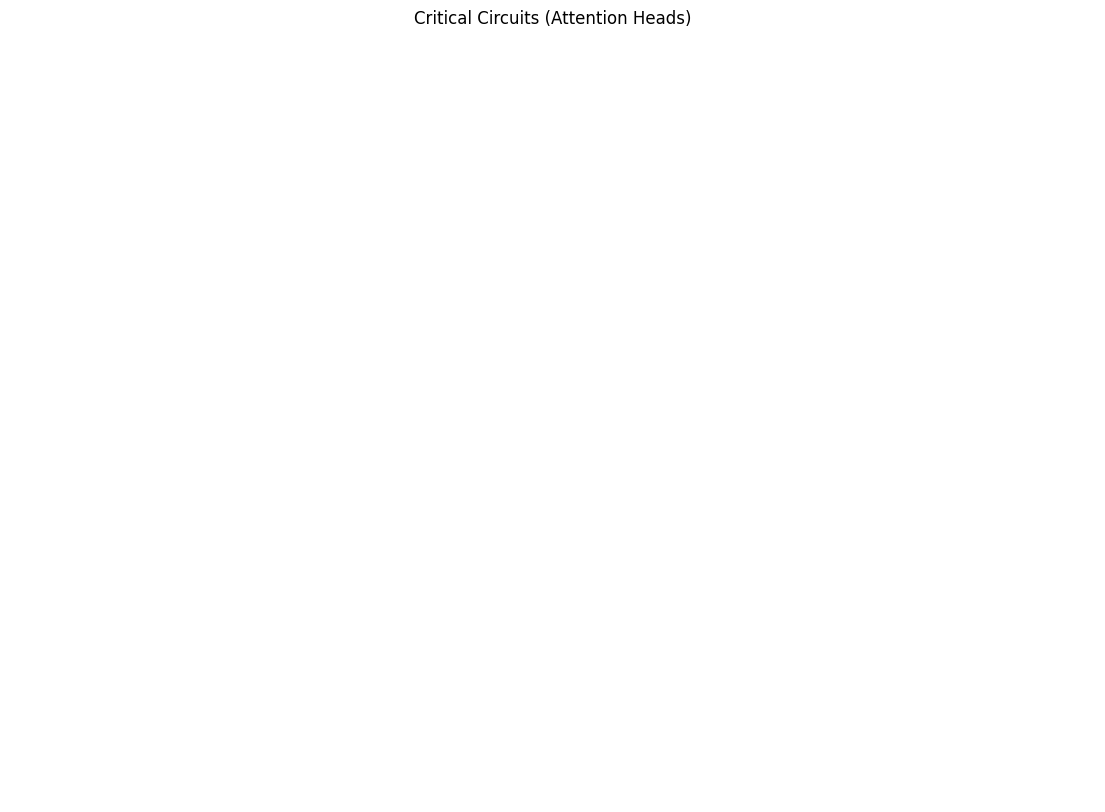

In [34]:
# ============================================================================
# CELL 16: BUILD CAUSAL GRAPH - Find the "circuit" for this prediction
# ============================================================================

# A "circuit" is the set of components that matter for a prediction.
# We find it by keeping only patches with effect above a threshold.

# --- Set threshold ---
# Only include patches where ΔP > threshold
# 0.01 = 1% change in probability
threshold = 0.01

# --- Find critical patches ---
# Returns list of (layer, head, position, delta) tuples
# where delta > threshold
critical_patches = find_critical_patches(
    patch_probs_heads,   # The position-wise patching results
    baseline,            # Baseline probabilities
    true_label=tgt_label,
    threshold=threshold
)
# Example: [(0, 3, 12, 0.15), (0, 5, 8, 0.08), ...]
# Meaning: L0H3 at timestep 12 has effect +0.15

# --- Build a graph ---
# Nodes: Timesteps ("Time 12") and Heads ("L0H3")
# Edges: Timestep → Head (if patching at that position affects that head's importance)
G = build_causal_graph(critical_patches)

# --- Visualize the graph ---
plot_causal_graph(G, title="Critical Circuits (Attention Heads)")

# INTERPRETATION:
# - Left nodes = input timesteps that matter
# - Right nodes = attention heads that matter
# - Edges = causal connections (which timesteps affect which heads)
# - Larger nodes = more connections (more important)
# - Brighter edges = stronger effect

**Input nodes**: Specific timesteps (e.g., "Time 12").

**Head nodes**: Attention heads (e.g., "L0H5").

Larger nodes imply more edges are connected to it.

Brighter edges imply magnitude of ΔP is larger after patching.

### Node Degrees and Edge Weights
**Node degrees**: How many edges connect to each node (importance as a hub).

**Edge weights**: How much each causal connection improves model performance.

Nodes and edges are ranked by influence

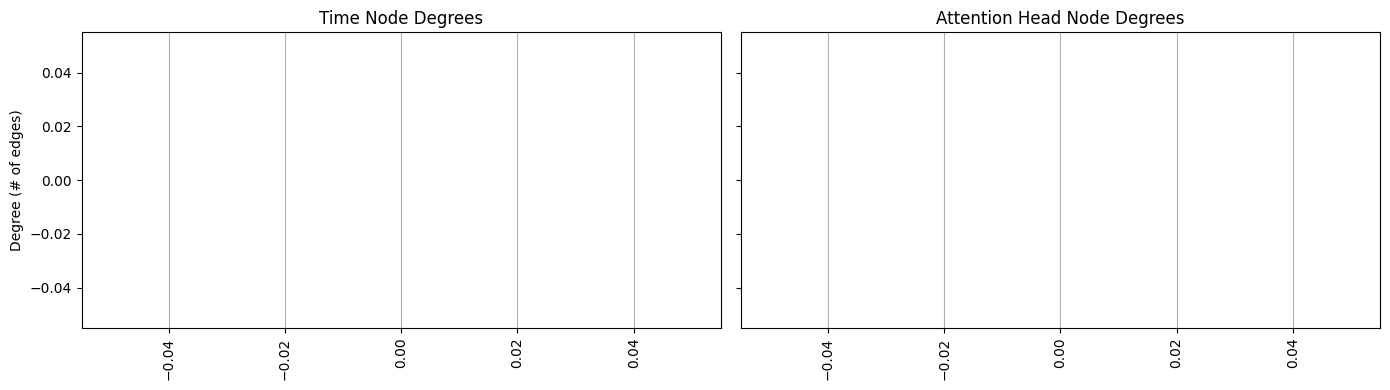

In [35]:
# ============================================================================
# CELL 17: ANALYZE GRAPH STRUCTURE - Node degrees and edge weights
# ============================================================================

# --- Compute node degrees ---
# Degree = number of edges connected to a node
# High degree = important hub in the circuit
degrees = dict(G.degree())  # {node_name: degree}

# Sort by degree (most connected first)
sorted_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
names = [x[0] for x in sorted_degrees]    # Node names
values = [x[1] for x in sorted_degrees]   # Degrees

# --- Get edges and sort by weight ---
# Edge weight = ΔP (effect strength)
edges = list(G.edges(data=True))  # [(src, dst, {weight: value}), ...]
sorted_edges = sorted(edges, key=lambda x: x[2]['weight'], reverse=True)
sources = [f"{u}->{v}" for u,v,d in sorted_edges]  # Edge labels
weights = [d['weight'] for u,v,d in sorted_edges]   # Edge weights

# --- Separate time nodes from head nodes ---
time_names = []
head_names = []
time_values = []
head_values = []

for name, val in zip(names, values):
    if name.startswith("T"):
        # This is a timestep node (e.g., "Time 12")
        time_names.append(name)
        time_values.append(val)
    elif name.startswith("L") and "H" in name:
        # This is a head node (e.g., "L0H3")
        head_names.append(name)
        head_values.append(val)

# --- Plot node degrees ---
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

# Left plot: Timestep degrees
axes[0].bar(time_names, time_values, color="seagreen")
axes[0].set_title("Time Node Degrees")
axes[0].set_ylabel("Degree (# of edges)")
axes[0].tick_params(axis='x', rotation=90)
axes[0].grid(axis='x')

# Right plot: Head degrees
axes[1].bar(head_names, head_values, color="steelblue")
axes[1].set_title("Attention Head Node Degrees")
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid(axis='x')

plt.tight_layout()
plt.show()

# INTERPRETATION:
# - Left: Which timesteps connect to the most heads? (input importance)
# - Right: Which heads receive from the most timesteps? (head importance)

## Interactive Experiment
Combining multiple critical patches affects model predictions.

1. Selects the top-k most influential edges.

2. Apply the clean activations to these multiple heads.

3. Report the change in confidence for the true label.

In [36]:
# ============================================================================
# CELL 18: MULTI-PATCHING - Patch multiple components at once
# ============================================================================

# So far we patched ONE component at a time.
# What if we patch MULTIPLE important components simultaneously?
# This tests whether the effects ADD UP.

@interact(top_k=widgets.IntSlider(min=1, max=10, step=1, value=5))
def multi_patch_with_slider(top_k):
    """
    Patch the top-k most important components at once.
    """
    # Get the top-k edges (highest ΔP)
    critical_edges = sorted_edges[:top_k]
    # Each edge is (source, dest, {weight: delta})
    # Example: ("Time 12", "L0H3", {weight: 0.15})
    
    # Apply all patches simultaneously
    # This replaces multiple head outputs at specific positions
    logits_patched_multi = patch_multiple_attention_heads_positions(
        model, src, tgt, critical_edges
    )
    
    # Convert to probabilities
    probs_multi = torch.softmax(logits_patched_multi, dim=1)[0].detach().cpu().numpy()
    
    # Compute improvement over baseline
    delta_p_true_multi = probs_multi[tgt_label] - baseline[tgt_label]
    
    # Print results
    print(f"Top-k = {top_k}")
    print(f"ΔP(true) after multi-patching: {delta_p_true_multi:.4f}")
    print(f"Final P(true) after multi-patching: {probs_multi[tgt_label]:.4f}")

# INTERPRETATION:
# - If ΔP increases as you add more patches → effects are ADDITIVE
# - If ΔP plateaus → you've found all the important components
# - If final P(true) is high → you've successfully "fixed" the misclassification

interactive(children=(IntSlider(value=5, description='top_k', max=10, min=1), Output()), _dom_classes=('widget…

In [37]:
# ============================================================================
# CELL 19: HEAD-TO-HEAD AND HEAD-TO-OUTPUT INFLUENCE
# ============================================================================

# --- Head-to-Head Influence ---
# Question: How much does each head affect other heads?
# Method: Measure MSE (mean squared error) between head outputs
# when we patch different heads
influence_matrix = sweep_head_to_head_influence(model, src, tgt)
# Shape: (num_layers, num_heads, num_layers, num_heads) = (3, 8, 3, 8)
# influence_matrix[l1, h1, l2, h2] = how much does patching L1H1 affect L2H2?

# --- Head-to-Output Influence ---
# Question: How much does each head directly affect the output?
# Method: Patch each head and measure ΔP for the true label
delta_p_matrix = sweep_head_to_output_deltas(model, src, tgt, tgt_label, num_classes)
# Shape: (num_layers, num_heads) = (3, 8)
# delta_p_matrix[l, h] = ΔP(true_label) when patching L_H_

# These matrices will be used to build more detailed causal graphs below

In [38]:
# ============================================================================
# CELL 20: BUILD DETAILED CAUSAL GRAPH WITH THRESHOLDS
# ============================================================================

def build_and_plot_graph(time_thresh=0.01,   # Min ΔP for Time→Head edges
                         head_thresh=0.15,   # Min MSE for Head→Head edges
                         class_thresh=0.01): # Min ΔP for Head→Class edges
    """
    Build a 3-layer causal graph:
      Timesteps → Attention Heads → Classes
    
    With optional Head→Head connections between layers.
    """
    
    # Create empty directed graph
    G = nx.DiGraph()
    node_labels = {}  # Short labels for display

    # --- Step 1: Find heads with significant output effect ---
    # Only include heads where |ΔP| > class_thresh
    selected_heads = {
        (l, h)
        for l in range(delta_p_matrix.shape[0])  # Loop layers
        for h in range(delta_p_matrix.shape[1])  # Loop heads
        if abs(delta_p_matrix[l, h]) > class_thresh
    }
    # selected_heads is a set like {(0, 3), (0, 5), (1, 2), ...}

    # --- Step 2: Add class nodes ---
    for c in range(num_classes):
        node = f"Class {c}"
        G.add_node(node)
        node_labels[node] = f"C {c}"  # Short label

    # --- Step 3: Add Head → Class edges ---
    # Connect important heads to the target class
    for (l, h) in selected_heads:
        head_node = f"L{l}H{h}"
        class_node = f"Class {tgt_label}"  # Only connect to true class
        G.add_node(head_node)
        node_labels[head_node] = head_node
        # Edge weight = how much this head affects the output
        G.add_edge(head_node, class_node, weight=float(delta_p_matrix[l, h]))

    # --- Step 4: Add Time → Head edges ---
    # Connect timesteps to heads where patching has effect
    for pos in range(patch_probs_heads.shape[2]):  # Loop timesteps
        time_node = f"Time {pos}"
        G.add_node(time_node)
        node_labels[time_node] = f"T {pos}"
        
        for (l, h) in selected_heads:
            # Compute ΔP for this (head, position) combination
            delta = patch_probs_heads[l, h, pos, tgt_label] - baseline[tgt_label]
            if abs(delta) > time_thresh:  # Only add if above threshold
                G.add_edge(time_node, f"L{l}H{h}", weight=float(delta))

    # --- Step 5: Add Head → Head edges (between layers) ---
    # Show how heads in one layer affect heads in other layers
    for (l1, h1) in selected_heads:
        for (l2, h2) in selected_heads:
            if l1 == l2:  # Skip same-layer connections
                continue
            score = influence_matrix[l1, h1, l2, h2]
            if abs(score) > head_thresh:
                G.add_edge(f"L{l1}H{h1}", f"L{l2}H{h2}", weight=float(score))

    # --- Step 6: Plot the graph ---
    fig = plot_structured_graph_with_heads(G, title=None, node_labels=node_labels)
    fig_holder.update(fig)  # Save for PDF export

# INTERPRETATION:
# - This creates a full circuit diagram
# - Timesteps on left, Heads in middle, Classes on right
# - Adjust thresholds to show more/fewer connections

In [39]:
# ============================================================================
# CELL 21: INTERACTIVE THRESHOLD-BASED GRAPH
# ============================================================================

# Create interactive sliders to adjust thresholds
interact(
    build_and_plot_graph,
    # Slider for Time→Head threshold
    time_thresh=FloatSlider(value=0.01, min=0.0, max=0.5, step=0.005, 
                            description='Time→Head ΔP'),
    # Slider for Head→Head threshold
    head_thresh=FloatSlider(value=0.15, min=0.0, max=0.5, step=0.01, 
                            description='Head→Head MSE'),
    # Slider for Head→Class threshold
    class_thresh=FloatSlider(value=0.1, min=0.0, max=0.8, step=0.01, 
                             description='Head→Class ΔP')
)

# --- Save button ---
save_btn = widgets.Button(description="Save current graph")
status = widgets.Label()

def on_save(_):
    """Save the current graph to PDF when button clicked."""
    status.value = fig_holder.save(path="tresholdgraph.pdf")

save_btn.on_click(on_save)
display(save_btn, status)

# USAGE:
# 1. Adjust sliders to find a clear graph (not too many edges)
# 2. Click "Save current graph" to export as PDF

interactive(children=(FloatSlider(value=0.01, description='Time→Head ΔP', max=0.5, step=0.005), FloatSlider(va…

Button(description='Save current graph', style=ButtonStyle())

Label(value='')

In [40]:
# ============================================================================
# CELL 22: TOP-K BASED GRAPH BUILDER
# ============================================================================

def build_and_plot_topk(
    top_k: int,              # How many top patches to include
    time_thresh: float = 0.0,   # Min ΔP for Time→Head edges
    head_thresh: float = 0.0,   # Min MSE for Head→Head edges
    class_thresh: float = 0.0   # Min ΔP for Head→Class edges
):
    """
    Build graph from the top-K most influential patches.
    
    Instead of using a fixed threshold, select the K patches
    with the highest |ΔP|.
    """
    
    # --- Step 1: Get top-K critical patches ---
    # Sort by absolute delta (effect size), take top K
    top_raw = sorted(critical_patches, key=lambda x: abs(x[3]), reverse=True)[:top_k]
    # Each item is (layer, head, position, delta)

    # --- Step 2: Create graph with all possible nodes ---
    G = nx.DiGraph()
    node_labels = {}
    
    # Add all timestep nodes
    for pos in range(patch_probs_heads.shape[2]):
        node = f"Time {pos}"
        G.add_node(node)
        node_labels[node] = f"T {pos}"
    
    # Add all head nodes
    for l in range(patch_probs_heads.shape[0]):
        for h in range(patch_probs_heads.shape[1]):
            node = f"L{l}H{h}"
            G.add_node(node)
            node_labels[node] = node
    
    # Add all class nodes
    for c in range(num_classes):
        node = f"Class {c}"
        G.add_node(node)
        node_labels[node] = f"C {c}"

    # --- Step 3: Add Time→Head edges from top-K ---
    head_to_sum = {}  # Track total delta per head
    head_set = set()  # Track which heads are included
    
    for l, h, pos, delta in top_raw:
        if abs(delta) < time_thresh:  # Apply threshold filter
            continue
        source = f"Time {pos}"
        destination = f"L{l}H{h}"
        G.add_edge(source, destination, weight=delta)
        head_set.add((l, h))
        
        # Accumulate delta for later Head→Class edges
        head_to_sum.setdefault((l, h), 0.0)
        head_to_sum[(l, h)] += delta
        
        # Print edge info
        print(f"{source} → {destination}, ΔP = {delta:.4f}")

    # --- Step 4: Add Head→Head edges ---
    # Connect heads that influence each other (between layers)
    for l1 in range(influence_matrix.shape[0]):
        for h1 in range(influence_matrix.shape[1]):
            for l2 in range(influence_matrix.shape[2]):
                for h2 in range(influence_matrix.shape[3]):
                    # Skip if source head not in top-K
                    if (l1, h1) not in head_set: 
                        continue
                    score = influence_matrix[l1, h1, l2, h2]
                    # Skip if below threshold or same layer
                    if abs(score) < head_thresh or l1 == l2: 
                        continue
                    G.add_edge(f"L{l1}H{h1}", f"L{l2}H{h2}", weight=score)

    # --- Step 5: Add Head→Class edges ---
    for (l, h), tot_delta in head_to_sum.items():
        if abs(tot_delta) < class_thresh:
            continue
        G.add_edge(f"L{l}H{h}", f"Class {tgt_label}", weight=tot_delta)
    
    # --- Step 6: Plot ---
    fig = plot_structured_graph_with_heads(
        G,
        title=None,
        node_labels=node_labels
    )
    fig_holder.update(fig)

In [41]:
# ============================================================================
# CELL 23: INTERACTIVE TOP-K GRAPH
# ============================================================================

# Create interactive sliders for top-K graph
interact(
    build_and_plot_topk,
    # Slider for number of top patches to include
    top_k=IntSlider(min=0, max=len(critical_patches), step=1, value=5, 
                    description="Top-K"),
    # Slider for Time→Head threshold
    time_thresh=FloatSlider(value=0.01, min=0.0, max=0.1, step=0.005, 
                            description='Time→Head ΔP'),
    # Slider for Head→Head threshold
    head_thresh=FloatSlider(value=0.15, min=0.0, max=0.5, step=0.01, 
                            description='Head→Head MSE'),
    # Slider for Head→Class threshold
    class_thresh=FloatSlider(value=0.01, min=0.0, max=0.5, step=0.005, 
                             description='Head→Class ΔP')
)

# --- Save button ---
save_btn = widgets.Button(description="Save current graph")
status = widgets.Label()

def on_save(_):
    """Save the current graph to PDF when button clicked."""
    status.value = fig_holder.save(path="topkgraph.pdf")

save_btn.on_click(on_save)
display(save_btn, status)

# USAGE:
# 1. Use Top-K slider to control complexity
# 2. Small K = simple graph (main circuit)
# 3. Large K = detailed graph (all connections)

interactive(children=(IntSlider(value=0, description='Top-K', max=0), FloatSlider(value=0.01, description='Tim…

Button(description='Save current graph', style=ButtonStyle())

Label(value='')

# Scaling up!


In [42]:
# ============================================================================
# CELL 24: SCALING UP - Configuration
# ============================================================================

# These settings control the automated pipeline below

# Maximum number of misclassified samples to analyze per class
# More pairs = more thorough but slower
MAX_PAIRS_PER_CLASS = 5

# Minimum ΔP to include in critical patches
# Lower = more patches, higher = fewer patches
THRESHOLD = 0.01  # 1% probability change

In [43]:
# ============================================================================
# CELL 25: AUTOMATED PIPELINE - Run patching on many pairs
# ============================================================================

def run_mode_pipeline(model, X_test, y_test, num_classes, mode, dataset_name, 
                      base_out_dir="Results", max_pairs_per_class=5):
    """
    Automatically run patching analysis on multiple sample pairs.
    
    This function:
    1. Finds misclassified samples for each class
    2. Pairs each with a correctly classified sample
    3. Runs all patching experiments
    4. Saves results to disk
    5. Aggregates results per class
    
    Parameters:
    -----------
    model : TimeSeriesTransformer
        The trained model to analyze
    X_test : torch.Tensor
        Test data, shape (num_samples, seq_len, input_dim)
    y_test : torch.Tensor
        Test labels, shape (num_samples,)
    num_classes : int
        Number of classes in the dataset
    mode : str
        "denoise" or "noise"
    dataset_name : str
        Name for output directory
    base_out_dir : str
        Root directory for results
    max_pairs_per_class : int
        Max misclassified samples per class to analyze
    """
    
    # --- Create output directory ---
    OUT_ROOT = os.path.join(base_out_dir, dataset_name, mode)
    os.makedirs(OUT_ROOT, exist_ok=True)
    num_layers = len(model.transformer_encoder.layers)

    # =========================================================================
    # STEP 1: CLASSIFY ALL TEST SAMPLES
    # =========================================================================
    records = []  # Will store prediction info for each sample
    model.eval()
    
    with torch.no_grad():
        for idx in range(len(X_test)):
            # Get single sample
            x = X_test[idx:idx+1].to(device)
            
            # Forward pass
            logits = model(x)
            probs = torch.softmax(logits, dim=1)[0]
            
            # Record prediction
            pred, true = int(probs.argmax()), int(y_test[idx])
            records.append({
                "idx": idx,
                "true": true,
                "pred": pred,
                "P_true": float(probs[true]),
                "P_pred": float(probs[pred])
            })
    
    df = pd.DataFrame(records)

    # --- Separate correct and incorrect predictions ---
    # Sort by confidence for better pair selection
    df_clean = df[df.true == df.pred].sort_values("P_true", ascending=False)
    df_mis = df[df.true != df.pred].sort_values("P_true", ascending=True)

    # =========================================================================
    # STEP 2: CREATE PAIRS FOR EACH CLASS
    # =========================================================================
    class_pairs = {}  # {class_id: [(clean_idx, corrupt_idx), ...]}
    
    for c in range(num_classes):
        # Get misclassified samples for this class (up to max)
        mis_c = df_mis[df_mis.true == c].head(max_pairs_per_class)
        if mis_c.empty:
            continue  # No misclassifications for this class
        
        # Get best correctly classified sample for this class
        clean_cands = df_clean[df_clean.true == c]
        if clean_cands.empty:
            continue  # No correct predictions for this class
        
        clean_idx = int(clean_cands.iloc[0].idx)  # Best correct sample
        
        # Create pairs: (clean, corrupt) for each misclassified sample
        class_pairs[c] = [(clean_idx, int(r.idx)) for _, r in mis_c.iterrows()]

    # =========================================================================
    # STEP 3: INITIALIZE STORAGE FOR AGGREGATION
    # =========================================================================
    class_layer_deltas = {c: [] for c in class_pairs}    # Per-layer ΔP
    class_head_deltas = {c: [] for c in class_pairs}     # Per-head ΔP
    class_headpos_deltas = {c: [] for c in class_pairs}  # Per-(head,pos) ΔP
    all_critical_patches = {c: [] for c in class_pairs}  # Critical patches
    
    # =========================================================================
    # STEP 4: RUN PATCHING PIPELINE FOR EACH PAIR
    # =========================================================================
    for c, pairs in class_pairs.items():
        for clean_idx, corrupt_idx in pairs:
            
            # --- Determine source and target based on mode ---
            if mode == "denoise":
                src_idx, tgt_idx = clean_idx, corrupt_idx
            elif mode == "noise":
                src_idx, tgt_idx = corrupt_idx, clean_idx
            else:
                raise ValueError("MODE must be 'denoise' or 'noise'")

            # --- Create output directory for this pair ---
            pair_dir = os.path.join(OUT_ROOT, f"class_{c}", f"pair_{src_idx}_{tgt_idx}")
            os.makedirs(pair_dir, exist_ok=True)

            # --- Load samples ---
            src = X_test[[src_idx]].to(device)
            tgt = X_test[[tgt_idx]].to(device)
            tgt_label = int(y_test[tgt_idx])

            # --- Get baseline (no patching) ---
            baseline = get_probs(model, tgt)

            # -----------------------------------------------------------------
            # EXPERIMENT 1: Layer-wise patching
            # -----------------------------------------------------------------
            pl = sweep_layerwise_patch(model, src, tgt, num_classes)
            plot_layerwise_influence(pl, baseline, tgt_label)
            plt.savefig(os.path.join(pair_dir, "patch_all_heads_per_layer.png"))
            plt.close()
            # Store for aggregation
            class_layer_deltas[c].append(pl[:, tgt_label] - baseline[tgt_label])

            # -----------------------------------------------------------------
            # EXPERIMENT 2: Head-wise patching
            # -----------------------------------------------------------------
            ph = sweep_heads(model, src, tgt, num_classes)
            plot_influence(ph, baseline, tgt_label)
            plt.savefig(os.path.join(pair_dir, "patch_each_head_heatmap.png"))
            plt.close()
            # Store for aggregation
            class_head_deltas[c].append(ph[:, :, tgt_label] - baseline[tgt_label])

            # -----------------------------------------------------------------
            # EXPERIMENT 3: Attention overlay (L0H0 only)
            # -----------------------------------------------------------------
            sal1 = get_attention_saliency(model, src.squeeze(0), 0, 0)
            sal2 = get_attention_saliency(model, tgt.squeeze(0), 0, 0)
            plot_timeseries_with_attention_overlay(
                [src.squeeze(0), tgt.squeeze(0)], 
                [sal1, sal2], 
                ["clean", "corrupt"], 
                title="Overlay L0H0"
            )
            plt.savefig(os.path.join(pair_dir, "attention_overlay_L0H0.png"))
            plt.close()

            # -----------------------------------------------------------------
            # EXPERIMENT 4: Position-wise head patching
            # -----------------------------------------------------------------
            p_hp = sweep_attention_head_positions(
                model, src, tgt, num_layers, 8, X_test.shape[1], num_classes
            )
            # Generate plots for each head (but don't save - too many files)
            for l in range(num_layers):
                for h in range(8):
                    plot_head_position_patch_heatmap(
                        p_hp, baseline, tgt_label, 
                        layer_idx=l, head_idx=h, 
                        title=f"L{l}H{h}"
                    )
                    plt.close()  # Close without saving
            # Store for aggregation
            class_headpos_deltas[c].append(p_hp[..., tgt_label] - baseline[tgt_label])

            # -----------------------------------------------------------------
            # EXPERIMENT 5: MLP layer patching
            # -----------------------------------------------------------------
            pm = sweep_mlp_layers(model, src, tgt, num_classes)
            plot_mlp_influence(pm, baseline, tgt_label)
            plt.savefig(os.path.join(pair_dir, "patch_mlp_layers.png"))
            plt.close()

            # -----------------------------------------------------------------
            # EXPERIMENT 6: MLP position patching
            # -----------------------------------------------------------------
            pm_pos = sweep_mlp_positions(
                model, src, tgt, num_layers, X_test.shape[2], num_classes
            )
            plot_mlp_position_patch_heatmap(pm_pos, baseline, tgt_label)
            plt.savefig(os.path.join(pair_dir, "patch_mlp_positions.png"))
            plt.close()

            # -----------------------------------------------------------------
            # EXPERIMENT 7: Find critical patches and build causal graph
            # -----------------------------------------------------------------
            crit = find_critical_patches(p_hp, baseline, tgt_label, threshold=THRESHOLD)
            all_critical_patches[c].extend(crit)

            G = build_causal_graph(crit)
            plot_causal_graph(G)
            plt.savefig(os.path.join(pair_dir, "causal_graph.png"))
            plt.close()

            # -----------------------------------------------------------------
            # EXPERIMENT 8: Multi-patch with top-5
            # -----------------------------------------------------------------
            top5 = sorted(crit, key=lambda x: abs(x[3]), reverse=True)[:5]
            edges = [
                (f"Time {pos}", f"L{layer}H{head}", {"weight": delta}) 
                for layer, head, pos, delta in top5
            ]
            logits_top5 = patch_multiple_attention_heads_positions(model, src, tgt, edges)
            probs_top5 = torch.softmax(logits_top5, dim=1)[0].detach().cpu().numpy()
            delta_top5 = probs_top5[tgt_label] - baseline[tgt_label]

            # -----------------------------------------------------------------
            # EXPERIMENT 9: Head-to-head influence
            # -----------------------------------------------------------------
            inf_h2h = sweep_head_to_head_influence(model, src, tgt)
            d_p = sweep_head_to_output_deltas(model, src, tgt, tgt_label, num_classes)

            # -----------------------------------------------------------------
            # SAVE RAW RESULTS
            # -----------------------------------------------------------------
            np.savez(
                os.path.join(pair_dir, "raw_results.npz"),
                baseline=baseline,
                layer_patch=pl,
                head_patch=ph,
                head_pos_patch=p_hp,
                mlp_patch=pm,
                mlp_pos_patch=pm_pos,
                inf_h2h=inf_h2h,
                delta_h2c=d_p
            )

            # -----------------------------------------------------------------
            # SAVE SUMMARY CSV
            # -----------------------------------------------------------------
            pd.DataFrame([{
                "src_idx": src_idx,
                "tgt_idx": tgt_idx,
                "true_label": tgt_label,
                "baseline_P": float(baseline[tgt_label]),
                "P_after_multi5": float(probs_top5[tgt_label]),
                "delta_multi5": float(delta_top5)
            }]).to_csv(os.path.join(pair_dir, "summary.csv"), index=False)

    # =========================================================================
    # STEP 5: AGGREGATE RESULTS PER CLASS
    # =========================================================================
    for c in class_pairs:
        class_dir = os.path.join(OUT_ROOT, f"class_{c}")
        os.makedirs(class_dir, exist_ok=True)

        # --- Compute averages across all pairs for this class ---
        avg_layer = np.mean(np.stack(class_layer_deltas[c]), axis=0)
        avg_head = np.mean(np.stack(class_head_deltas[c]), axis=0)
        avg_headpos = np.mean(np.stack(class_headpos_deltas[c]), axis=0)

        # Save aggregated data
        np.savez(
            os.path.join(class_dir, "aggregated_deltas.npz"),
            avg_layer=avg_layer,
            avg_head=avg_head,
            avg_headpos=avg_headpos
        )

        # --- Plot: Average ΔP per layer ---
        plt.figure(figsize=(6, 4))
        plt.bar(range(num_layers), avg_layer, color=plt.cm.Blues(0.6))
        plt.xlabel("Layer")
        plt.ylabel("Avg ΔP")
        plt.title(f"Class {c} — Avg ΔP per Layer")
        plt.tight_layout()
        plt.savefig(os.path.join(class_dir, "class_avg_layer.png"))
        plt.close()

        # --- Plot: Average ΔP per head (heatmap) ---
        plt.figure(figsize=(8, 6))
        plt.imshow(avg_head, aspect='auto', cmap="Blues",
                   vmin=avg_head.min(), vmax=avg_head.max())
        plt.colorbar(label="Avg ΔP")
        plt.xlabel("Head")
        plt.ylabel("Layer")
        plt.title(f"Class {c} — Avg ΔP per Head")
        plt.tight_layout()
        plt.savefig(os.path.join(class_dir, "class_avg_head_heatmap.png"))
        plt.close()

        # --- Plot: Average ΔP per (head, position) ---
        L, H, P = avg_headpos.shape
        arr = avg_headpos.reshape(L * H, P)  # Flatten layers×heads
        ylabels = [f"L{i}H{j}" for i in range(L) for j in range(H)]

        plt.figure(figsize=(12, L * H * 0.3))
        sns.heatmap(
            arr, cmap="Blues", center=0,
            xticklabels=max(P // 20, 1), 
            yticklabels=ylabels,
            cbar_kws={'label': 'Avg ΔP'}
        )
        plt.xlabel("Time Step")
        plt.ylabel("Layer×Head")
        plt.title(f"Class {c} — Avg ΔP Head×Position")
        plt.tight_layout()
        plt.savefig(os.path.join(class_dir, "class_avg_headpos_heatmap.png"))
        plt.close()

    print(f"Done: {mode.upper()} mode complete at {OUT_ROOT}")

### Possible Dataset names
- JapaneseVowvels
- LSST
- PenDigits

## DEPENDING ON THE DATASET, RUNNING CAN TAKE SOME TIME

In [44]:
# ============================================================================
# CELL 26: RUN THE FULL PIPELINE
# ============================================================================

# Uncomment the lines below to run the full analysis:

# --- Run DENOISE mode ---
# This patches clean→corrupt to find what fixes misclassifications
# run_mode_pipeline(model, X_test, y_test, num_classes, mode="denoise", dataset_name=DATASET_NAME)

# --- Run NOISE mode ---
# This patches corrupt→clean to find what breaks correct predictions
# run_mode_pipeline(model, X_test, y_test, num_classes, mode="noise", dataset_name=DATASET_NAME)

# WHAT GETS SAVED:
# Results/{DATASET_NAME}/
# ├── denoise/
# │   └── class_{c}/
# │       ├── pair_{src}_{tgt}/
# │       │   ├── raw_results.npz      # All patching data
# │       │   ├── summary.csv          # Key metrics
# │       │   ├── patch_*.png          # Visualizations
# │       │   └── causal_graph.png     # Circuit diagram
# │       ├── aggregated_deltas.npz    # Class averages
# │       └── class_avg_*.png          # Aggregate plots
# └── noise/
#     └── [same structure]

# RUNTIME ESTIMATES:
# - JapaneseVowels: ~5 minutes
# - PenDigits: ~10 minutes
# - LSST: ~15 minutes